# 클린업 3주차 - BERT

클린업 3주차에서는 두 가지에 대해서 실습해보려고 합니다.

1. BERT

2. PEFT (Parameter-Efficient Fine Tuning)

첫 번째로, BERT에 대해 코드 실습을 해봄으로써 어떻게 활용할 수 있을지 알아보겠습니다.

두 번째 PEFT에서는 Fine Tuning을 통해 질의응답 문제를 풀어보도록 하겠습니다.

In [1]:
# !pip install ipywidgets

# 라이브러리 불러오기

먼저 필요한 라이브러리를 불러오도록 할게요.

BERT는 아래에서 볼 수 있듯이 Huggingface의 `transformers` 모듈로 쉽게 불러올 수 있습니다.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import BertTokenizer, BertModel, BertForMaskedLM

# 모델 살펴보기 - Tokenizer

첫 번째로 알아볼 것은 Tokenizer입니다.

BERT를 사용하기 위해서는 Tokenizer와 Model이 필요합니다.

Tokenizer는 이름에서 예상할 수 있듯이, 임베딩을 만들기 위해 토큰화하는 작업입니다.

예시를 통해 같이 알아보겠습니다.

먼저 `from_pretrained()` 메서드로 BertTokenizer를 불러와줄게요.

이 메서드는 사전 학습 모델을 불러오는 메서드로, 여러 체크포인트로부터 모델을 불러올 수 있습니다.

여기서는 가장 기본적인 `bert-base-uncased` 버전을 불러오겠습니다.

세부사항은 아래의 링크를 확인해주세요!

* google-bert: https://huggingface.co/google-bert/bert-base-uncased

In [3]:
# Tokenizer 불러오기
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


이제 예시 문장을 토큰화해볼게요

In [4]:
# 토큰화 예시 (1)
example = "This is a test sentence"

encoded_inputs = tokenizer(example)
print(encoded_inputs)

{'input_ids': [101, 2023, 2003, 1037, 3231, 6251, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


토큰화한 결과, 총 3가지의 Key-Value들을 확인할 수 있습니다.

각각이 의미하는 것은 다음과 같습니다.

* `input_ids`: 모델의 임베딩에 접근하기 위한 인덱스
* `token_type_ids`: 각 token이 어떤 문장에 속하는지를 나타내는 리스트. SentA는 0, SentB는 1을 부여함
* `attention_mask`: attention 연산이 수행되어야 할 token과 무시해야 할 token을 구별하는 정보가 담긴 리스트

  예를 들어 [PAD] 등의 토큰은 0을 부여해서 Attention 연산을 하지 않음

이번에는 어떻게 토큰화되었는지 확인해보겠습니다.

`convert_ids_to_token()` 메서드를 사용하면 아래와 같이 인덱스를 해독할 수 있습니다.

In [5]:
# 토큰화 결과 확인하기
tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids'])

['[CLS]', 'this', 'is', 'a', 'test', 'sentence', '[SEP]']

예시를 보면 맨 앞에 [CLS] 토큰과 마지막에 [SEP] 토큰을 추가하여 문장을 구별하는 것을 볼 수 있습니다.

BERT가 사용하는 특수 토큰들은 5가지가 있습니다.

* padding token : `[PAD]`(0)
* unknown token : `[UNK]`(100)
* classifier token : `[CLS]`(101)
* seperator token : `[SEP]`(102)
* mask token : `[MASK]`(103)

또 다른 예시를 알아볼까요?

hackaton이라는 단어는 어떻게 토큰화될까요?

In [6]:
# 토큰화 예시 (2)
example = "During the weekend, our team participated in a hackathon, where we developed an innovative app for tracking daily water intake"

encoded_inputs = tokenizer(example)
print(encoded_inputs)
print(tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids']))

{'input_ids': [101, 2076, 1996, 5353, 1010, 2256, 2136, 4194, 1999, 1037, 20578, 8988, 2239, 1010, 2073, 2057, 2764, 2019, 9525, 10439, 2005, 9651, 3679, 2300, 13822, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'during', 'the', 'weekend', ',', 'our', 'team', 'participated', 'in', 'a', 'hack', '##ath', '##on', ',', 'where', 'we', 'developed', 'an', 'innovative', 'app', 'for', 'tracking', 'daily', 'water', 'intake', '[SEP]']


WordPiece 알고리즘으로 subword를 만드는 BERT답게 "hack" + "##ath" + "##on"으로 나누고 있네요

Tokenizer는 아래의 예시처럼 2개의 문장 또한 받을 수 있습니다!

In [7]:
# 토큰화 예시 (3)
example1 = "My dog is barking over the door"
example2 = "The scent of freshly baked cookies filled the kitchen"

encoded_inputs = tokenizer(example1, example2)
print(encoded_inputs)
print(tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids']))

{'input_ids': [101, 2026, 3899, 2003, 19372, 2058, 1996, 2341, 102, 1996, 6518, 1997, 20229, 17776, 16324, 3561, 1996, 3829, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'my', 'dog', 'is', 'barking', 'over', 'the', 'door', '[SEP]', 'the', 'scent', 'of', 'freshly', 'baked', 'cookies', 'filled', 'the', 'kitchen', '[SEP]']


여기서 살펴볼 수 있는 점은 `token_type_ids`를 0, 1로 부여하여 두 문장을 구분하고 있다는 것입니다.

또한 [CLS] ~ [SEP] ~ [SEP]로 구분하고 있죠.

이 외에도 Tokenizer에는 다양한 파라미터들이 존재합니다.

* `return_tensors`: `pt`로 설정하면 PyTorch의 텐서가 반환됩니다.

* `padding`
  * True 혹은 `longest` : batch에서 가장 긴 텍스트에 맞춰 padding
  * `max_length` : max_length 인자가 주어진 경우 그 길이에 맞춰 padding. 주어지지 않았다면 모델의 최대 길이(BERT의 경우 512)에 맞춰 padding
  * False 혹은 `do_not_pad`(default) : padding X

* `truncation`
  * True 혹은 `longest_first` : max_length 인자가 주어진 경우 그 길이에 맞춰 truncate. 만약 `List[List[str]]` 형태로 입력이 들어온 경우 두 sentence 중 긴 sentence를 먼저 truncate
  * `only_first` : max_length 인자가 주어진 경우 그 길이에 맞춰 truncate. 만약 `List[List[str]]` 형태로 입력이 들어온 경우 두 sentence 중 첫 번째 sentence만 truncate
  * `only_second` : max_length 인자가 주어진 경우 그 길이에 맞춰 truncate. 만약 `List[List[str]]` 형태로 입력이 들어온 경우 두 sentence 중 두 번째 sentence만 truncate
  * False 혹은 `do_not_truncate`(default) : truncate X

In [8]:
# 토큰화 예시 (4)
example1 = "My dog is barking over the door"
example2 = "The scent of freshly baked cookies filled the kitchen"

encoded_inputs = tokenizer(example1, example2, return_tensors="pt",
                           padding=True, max_length=15, truncation=True)
print(encoded_inputs)
print(tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids'].squeeze().tolist()))

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


{'input_ids': tensor([[  101,  2026,  3899,  2003, 19372,  2058,  1996,   102,  1996,  6518,
          1997, 20229, 17776, 16324,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
['[CLS]', 'my', 'dog', 'is', 'barking', 'over', 'the', '[SEP]', 'the', 'scent', 'of', 'freshly', 'baked', 'cookies', '[SEP]']


# 모델 살펴보기 - BertModel

이번에는 모델을 살펴보도록 하겠습니다. 먼저 모델을 불러와줄게요!

In [9]:
# 모델 불러오기

model = BertModel.from_pretrained('bert-base-uncased')

In [10]:
# 모델 사이즈
model.num_parameters()

109482240

모델 사이즈는 대략 110M 개의 파라미터가 있습니다.

가장 먼저 `BertEmbedding`에 대해 알아볼게요. `BertEmbedding`은 어떻게 구성되어 있을까요?

In [11]:
# BertEmbedding
model.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

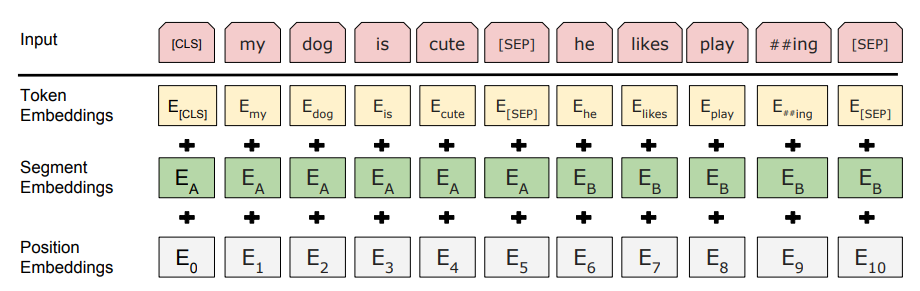

우리가 배웠던 대로 총 3가지의 임베딩이 존재하고 있는 것을 볼 수 있습니다.

* `word_embeddings`
  * 이름에서 알아볼 수 있듯, BERT의 토큰 임베딩
  * 30,522개의 단어를 사용하고 있고 각 단어의 임베딩 차원은 768
* `position_embeddings`
  * BERT의 위치 임베딩
  * 최대 512개의 토큰까지만 입력으로 받을 수 있음
* `token_type_embeddings`
  * BERT의 세그먼트 임베딩
  * SentA와 SentB를 구분함

모델은 어떻게 작동할까요? 코드의 일부분을 보도록 하겠습니다.

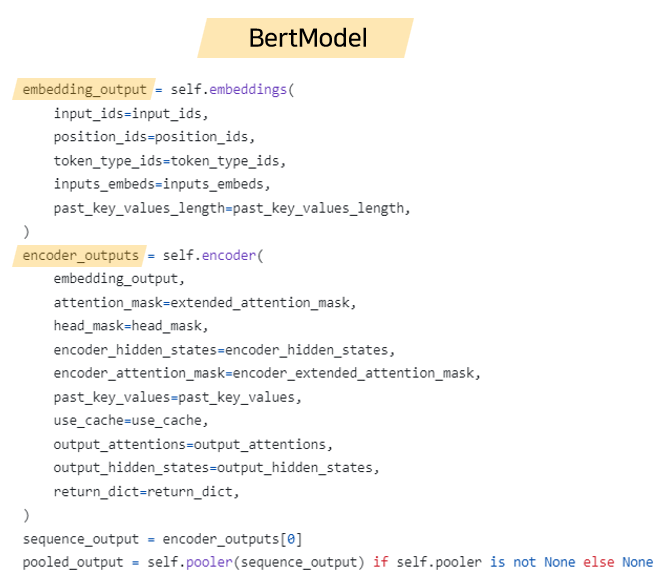

다음은 `BertModel`의 학습과정의 일부분입니다.

여기서는 `embedding_output`과 `encoder_outputs`라는 두 개의 변수를 볼 수가 있네요.

`embedding_output`은 `input_ids, position_ids, token_type_ids`를 받아서 최종적인 임베딩을 생성합니다.

`encoder_outputs`는 최종 임베딩 `embedding_output`을 Encoder를 통해 학습하여 얻어집니다.

BertModel은 위의 토큰화 결과를 활용하여 사용할 수 있습니다.

In [12]:
example = "During the weekend, our team participated in a hackathon, where we developed an innovative app for tracking daily water intake"

encoded_inputs = tokenizer(example, return_tensors="pt")
outputs = model(**encoded_inputs)

In [13]:
print(outputs[0].shape)
print(outputs[1].shape)

torch.Size([1, 26, 768])
torch.Size([1, 768])


총 26개의 토큰에 대해서 계산한다는 것을 볼 수 있습니다.

이번엔 간단한 MLM 문제에 적용해보겠습니다. 모델은 [MASK] 토큰에 대해서

어떻게 예측할까요?

이를 위해서는 `BertForMaskedLM` 클래스를 사용해야 합니다. `BertModel`은 현재 제대로 인식하지 못하는 오류가 있습니다.

In [14]:
# 모델 불러오기
mlm_model = BertForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5개의 예제 문장에 대해 어떻게 계산하고 있는지 살펴보겠습니다.
* The cat slept peacefully on the warm, sunlit windowsill"
* "She smiled brightly at her reflection in the mirror"
* "The puppy eagerly wagged its tail, waiting for a treat"
* "The book lay open on the table, its pages fluttering in the breeze"
* "The scent of freshly baked cookies filled the kitchen"

여기서 주어 부분을 [MASK]하면 모델은 어떤 예측 결과를 내놓을까요?

In [15]:
# 마스킹된 문장
masked_sents = ["The [MASK] slept peacefully on the warm, sunlit windowsill",
 "[MASK] smiled brightly at her reflection in the mirror",
 "The [MASK] eagerly wagged its tail, waiting for a treat",
 "The [MASK] lay open on the table, its pages fluttering in the breeze",
 "The scent of freshly baked [MASK] filled the kitchen"]

In [16]:
# 토큰화하기
# [MASK] 토큰의 위치 또한 저장해줍시다

outputs = []
masked_positions = []
for sent in masked_sents:
    encoded_inputs = tokenizer(sent, return_tensors="pt")
    output = mlm_model(**encoded_inputs)
    masked_position = torch.where(encoded_inputs["input_ids"] == 103)[1].item()
    masked_positions.append(masked_position)
    outputs.append(output)

In [17]:
# [MASK] 위치 확인하기
print(masked_positions)

[2, 1, 2, 2, 6]


In [18]:
# 예측 확인하기
# [MASK] 토큰에 대해 상위 5개 예측이 무엇인지 확인합니다

predictions = []  # 모든 [MASK]에 대한 예측을 담을 리스트
for i, output in enumerate(outputs):
    embeddings = output[0]
    probs = F.softmax(embeddings[0, masked_positions[i]], dim=-1)
    top_k_weights, top_k_indices = torch.topk(probs, 5, sorted=True)
    temp = []   # 각 5개 예측을 담을 리스트
    for i, w in zip(top_k_indices, top_k_weights):
        word = tokenizer.convert_ids_to_tokens(i.item())
        temp.append((word, w.item()))
    predictions.append(temp)

In [19]:
# 각 문장 별 [MASK]에 대한 예측 확인하기

for i, preds in enumerate(predictions):
    print(f"{i+1}. {masked_sents[i]}")
    for pred, weight in preds:
        print(f"[MASK] -> \t{pred} : {weight:.6f}")
    print("-"*40)
    print()

1. The [MASK] slept peacefully on the warm, sunlit windowsill
[MASK] -> 	children : 0.332728
[MASK] -> 	guests : 0.051293
[MASK] -> 	family : 0.040248
[MASK] -> 	kids : 0.035837
[MASK] -> 	girls : 0.025943
----------------------------------------

2. [MASK] smiled brightly at her reflection in the mirror
[MASK] -> 	she : 0.817717
[MASK] -> 	liz : 0.004796
[MASK] -> 	sarah : 0.004576
[MASK] -> 	olivia : 0.003851
[MASK] -> 	emma : 0.003608
----------------------------------------

3. The [MASK] eagerly wagged its tail, waiting for a treat
[MASK] -> 	dog : 0.339979
[MASK] -> 	cat : 0.158903
[MASK] -> 	wolf : 0.028312
[MASK] -> 	bird : 0.026006
[MASK] -> 	animal : 0.022907
----------------------------------------

4. The [MASK] lay open on the table, its pages fluttering in the breeze
[MASK] -> 	book : 0.646765
[MASK] -> 	journal : 0.171553
[MASK] -> 	magazine : 0.031010
[MASK] -> 	notebook : 0.022026
[MASK] -> 	newspaper : 0.014822
----------------------------------------

5. The scent of

단순 예측의 결과가 어떤가요? BERT가 문맥을 파악하여 그럴듯한 결과를 내놓는 것을 알 수 있습니다.

하지만 1번의 경우, cat 대신 children을 예측했죠. 이렇듯 잘못 예측할 가능성 또한 충분히 존재합니다.

3주차 첫 번째는 BERT에 대한 실습을 진행했습니다. BERT에 대한 대략적인 소개와 어떻게 사용할 수 있는지 보았죠.

첫 번째 코드 실습은 여기서 마치도록 하겠습니다!